In [1]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Use ggplot
matplotlib.style.use('ggplot')

# Load original dataset that was used to generate samples
df_original = pd.read_csv('../1_sample_preperation/source/d_clean_remove_small_samples.csv')

# Load JSON data into a dictionary
with open('results_dataframe.json', 'r') as file:
    data = json.load(file)

# Convert dictionary to DataFrame
df = pd.DataFrame(data)
df = df.drop(columns=['prompt_template','org_folder','file_path','regex_counts','failed_to_capture','extracted_data_len'])

features = ['target_material','target_thickness','pulse_width','energy','spot_size','intensity','power','cutoff_energy']

# Explode the 'extracted_rows' column to create a new row for each entry
df = df.explode('extracted_rows')

# Filter out rows where 'extracted_rows' is NaN
df = df[df['extracted_rows'].notna()]

# Convert list in 'extracted_rows' to separate columns
if not df.empty and isinstance(df.iloc[0]['extracted_rows'], list):
    df[features] = pd.DataFrame(df['extracted_rows'].tolist(), index=df.index)

# Replace all whitespace in the 'model' column
df['model'] = df['model'].str.replace(r'\s+', '', regex=True)

# Drop the original 'extracted_rows' column
df = df.drop(columns=['extracted_rows'])

# Reset the index
df = df.reset_index(drop=True)

df

model      prompt_method prompt_short  sample_size  \
0       claude-3-sonnet-20240229   chain_of_thought          cot    rs_size_5   
1       claude-3-sonnet-20240229   chain_of_thought          cot    rs_size_5   
2       claude-3-sonnet-20240229   chain_of_thought          cot    rs_size_5   
3       claude-3-sonnet-20240229   chain_of_thought          cot    rs_size_5   
4       claude-3-sonnet-20240229   chain_of_thought          cot    rs_size_5   
...                          ...                ...          ...          ...   
123325            phi3:mini-128k  reverse_prompting           rp  rs_size_100   
123326            phi3:mini-128k  reverse_prompting           rp  rs_size_100   
123327            phi3:mini-128k  reverse_prompting           rp  rs_size_100   
123328            phi3:mini-128k  reverse_prompting           rp  rs_size_150   
123329            phi3:mini-128k  reverse_prompting           rp  rs_size_150   

       target_material       target_thickness      pulse_width  \
0              plastic                   0.48               30   
1            aluminium                    0.3               30   
2              plastic                   0.62               30   
3        polypropylene                   0.76              279   
4                 gold                   0.78              475   
...                ...                    ...              ...   
123325         plastic                  0.145            3.631   
123326         plastic                  0.545             1.58   
123327        silicone                    279            3.796   
123328         plastic                  0.809  568000000000000   
123329         plastic  493000000000000000000   28460000000000   

                          energy              spot_size  \
0                           2.31                    3.3   
1                           1.65                    3.3   
2                           2.39                    3.3   
3                           2.41                    3.3   
4                           10.5                    3.3   
...                          ...                    ...   
123325                     2.671                  3.837   
123326                       3.5                 99.161   
123327                     4.555  560400000000000000000   
123328                         4                    3.2   
123329  6504999999999999737856.0    7234000000000000000   

                       intensity            power  cutoff_energy  
0          625000000000000000000   76900000000000            5.4  
1           44600000000000000000    5490000000000            4.2  
2          646000000000000000000   79500000000000            5.6  
3          652000000000000000000   80200000000000            5.6  
4       1150000000000000000000.0  141000000000000           11.9  
...                          ...              ...            ...  
123325      20560000000000000000            5.268  7913000000000  
123326                     3.265            3.521          5.142  
123327     147800000000000000000            7.518              7  
123328                       4.5              4.5          0.998  
123329             1100000000000              6.9  8370000000000  

[123330 rows x 12 columns]

Unique Materials: 393


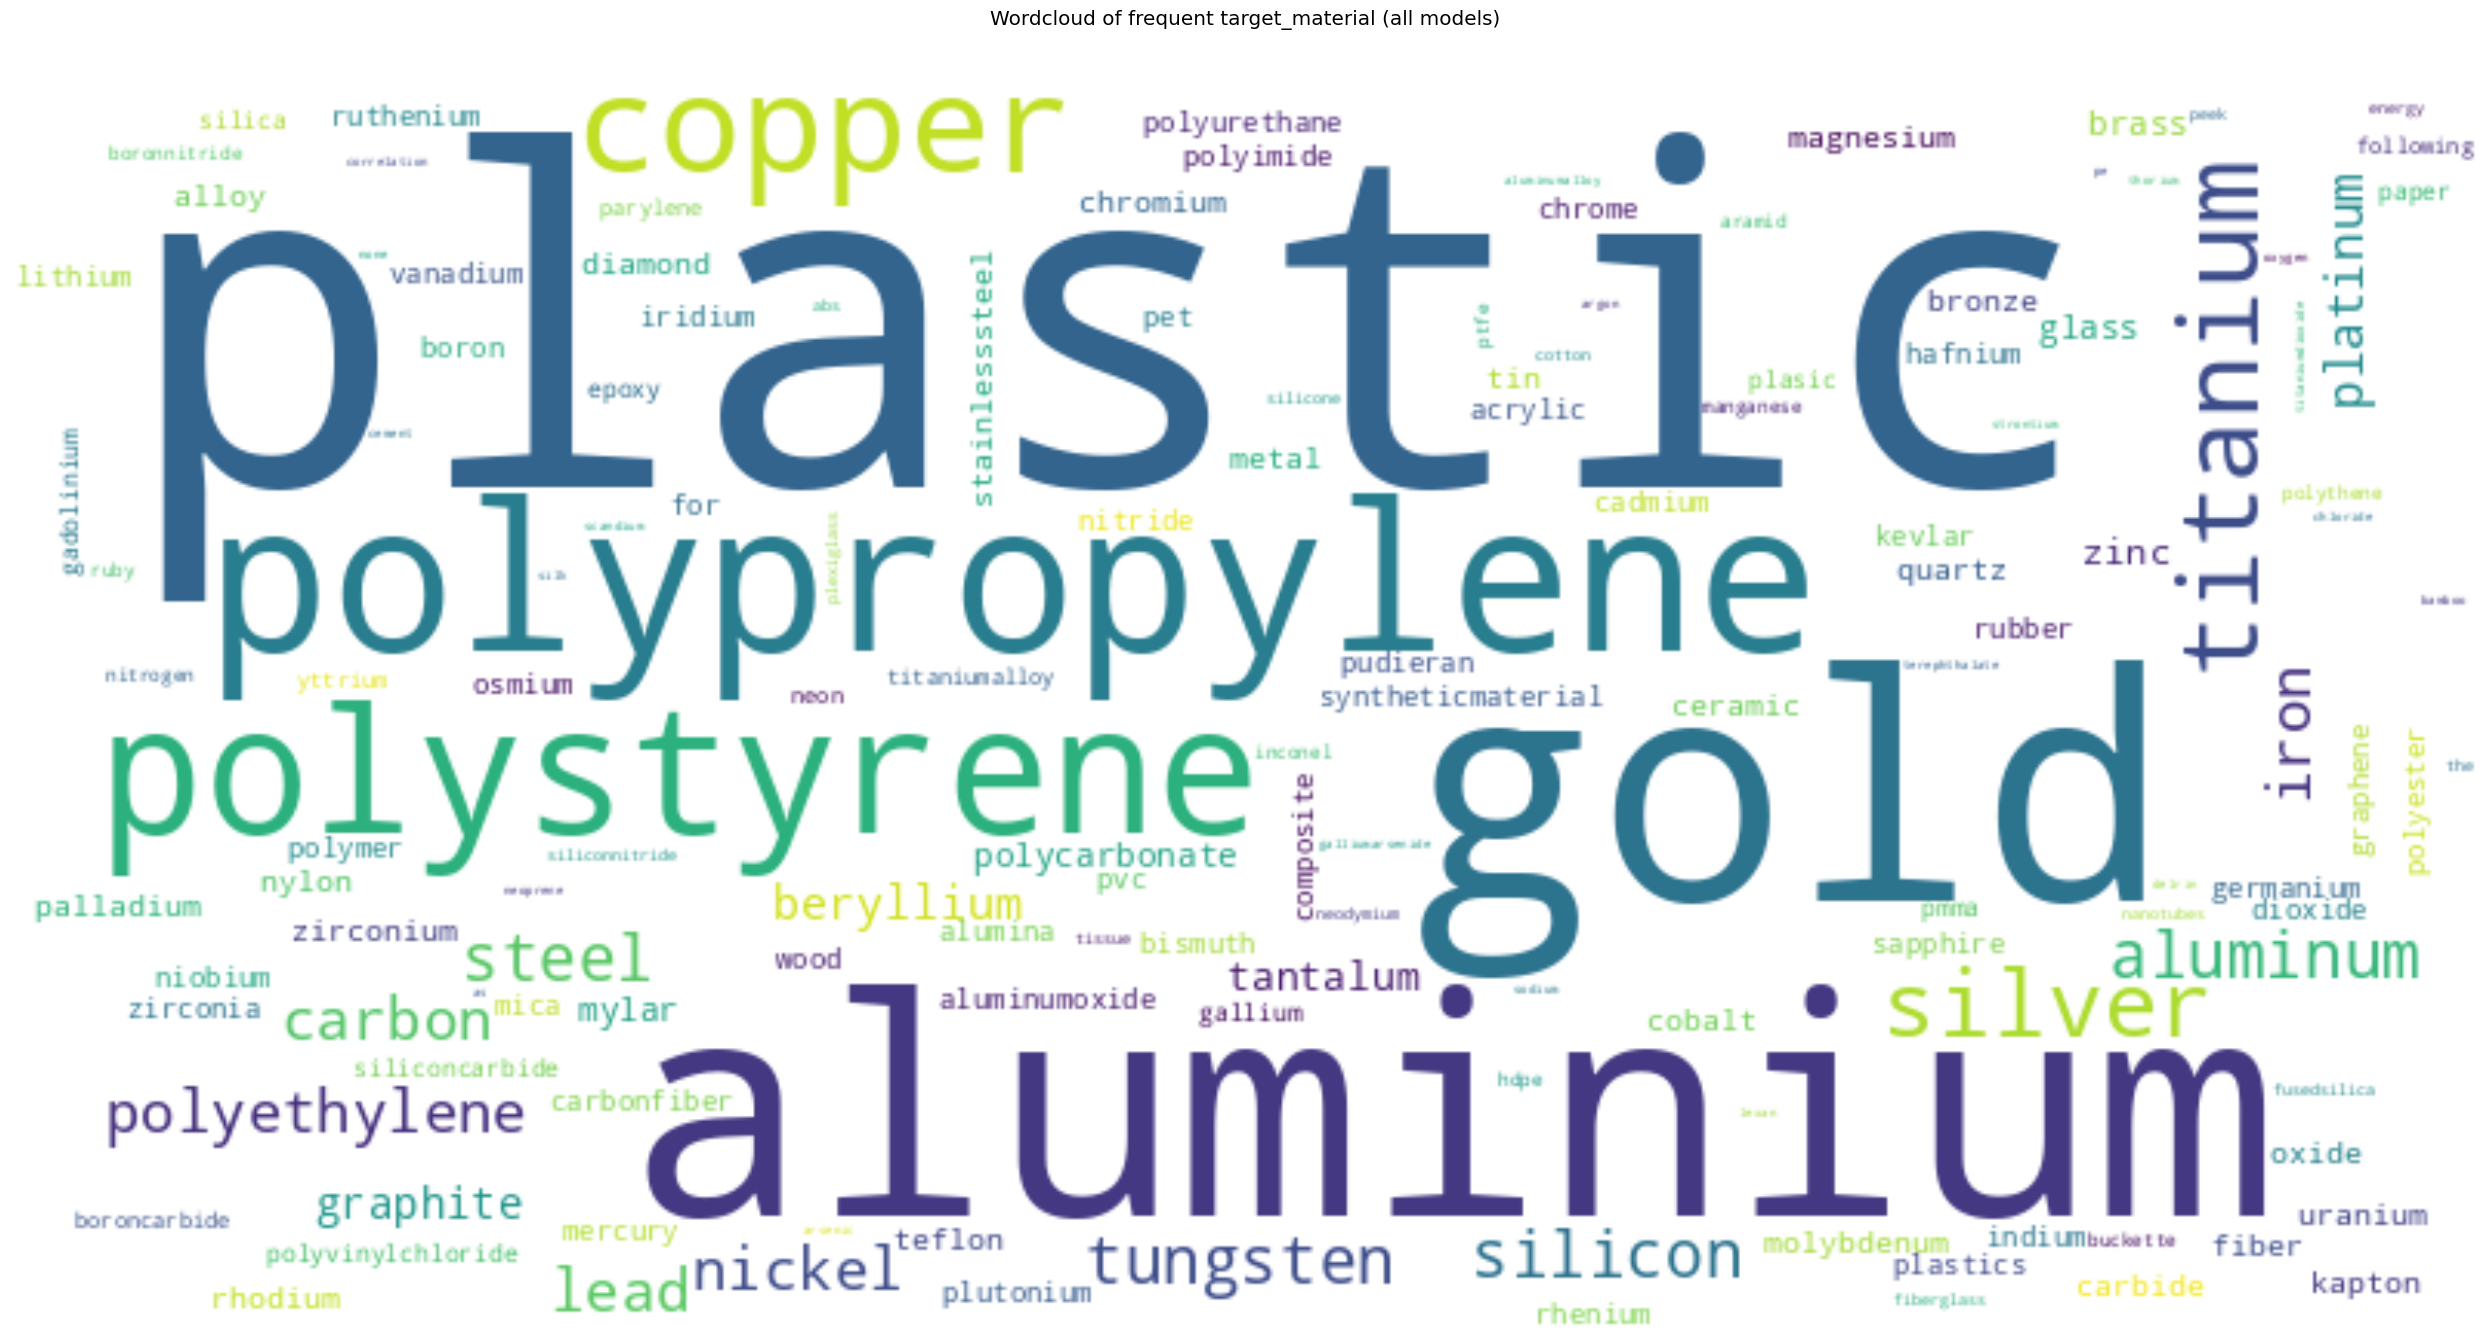

In [15]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it has already been processed to include the 'target_material' column correctly

# Count the occurrences of each 'target_material'
material_counts = df['target_material'].value_counts()

print('Unique Materials:',len(df['target_material'].unique()))

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# Generate a word cloud using the frequencies
wordcloud.generate_from_frequencies(material_counts.to_dict())

# Display the WordCloud image:
plt.figure(figsize=(25, 15))
plt.title('Wordcloud of frequent target_material (all models)',y=1.05)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels

plt.tight_layout()

plt.savefig('./images/word_cloud_target_material.jpg',dpi=800)
plt.show()

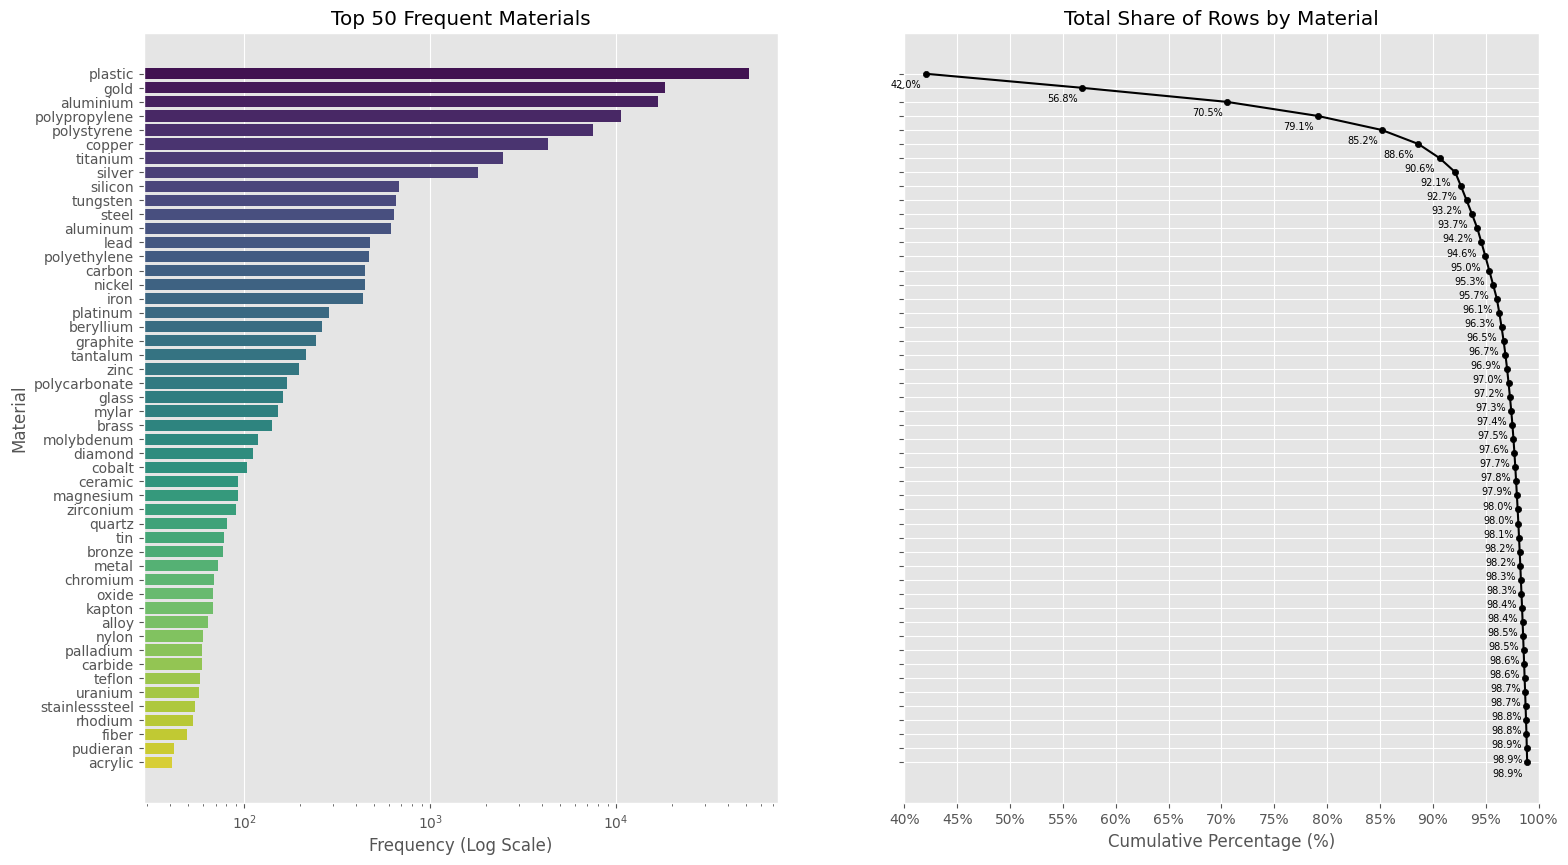

<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming 'material_counts' holds the value counts of 'target_material' from your DataFrame
top_25_materials = material_counts.head(50)  # Get the top 50 materials for better illustration

# Create a DataFrame from the top 25 materials for easier plotting
top_25_df = pd.DataFrame(top_25_materials).reset_index()
top_25_df.columns = ['target_material', 'count']

# Calculate cumulative percentage
total_rows = df.shape[0]  # Total number of rows in the original DataFrame
top_25_df['cumulative_percent'] = top_25_df['count'].cumsum() / total_rows * 100

# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10), sharey=True)  # Share y-axis across subplots

# Left subplot for frequency
sns.barplot(x='count', y='target_material', data=top_25_df, ax=axes[0], hue='target_material',palette='viridis')
axes[0].set_xscale('log')
axes[0].set_xlabel('Frequency (Log Scale)')
axes[0].set_ylabel('Material')
axes[0].set_title('Top 50 Frequent Materials')

# Right subplot for cumulative percentage
sns.lineplot(x='cumulative_percent', y='target_material', data=top_25_df, ax=axes[1],color='black')
axes[1].set_xlabel('Cumulative Percentage (%)')
axes[1].set_title('Total Share of Rows by Material')

# Set x-axis to have a tick every 5 percent
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))

# Optionally, you can format the ticks to show them as percentages
axes[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100))

# If you want to limit the x-axis to show up to 100% only
axes[1].set_xlim(40, 100)

# Annotate each point on the line plot
for index, row in top_25_df.iterrows():
    axes[1].annotate(f"{row['cumulative_percent']:.1f}%", 
                     (row['cumulative_percent'], row['target_material']), 
                     textcoords="offset points", 
                     xytext=(-14,-10), 
                     ha='center', 
                     color='black', 
                     size=7,
    )
# Plotting the points as black dots
axes[1].scatter(top_25_df['cumulative_percent'], top_25_df['target_material'], color='black', s=20)  # s is the size of the dot

plt.show()

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig('./images/top_50_materials_comparison.jpg', dpi=300)
# Display the plot
plt.show()


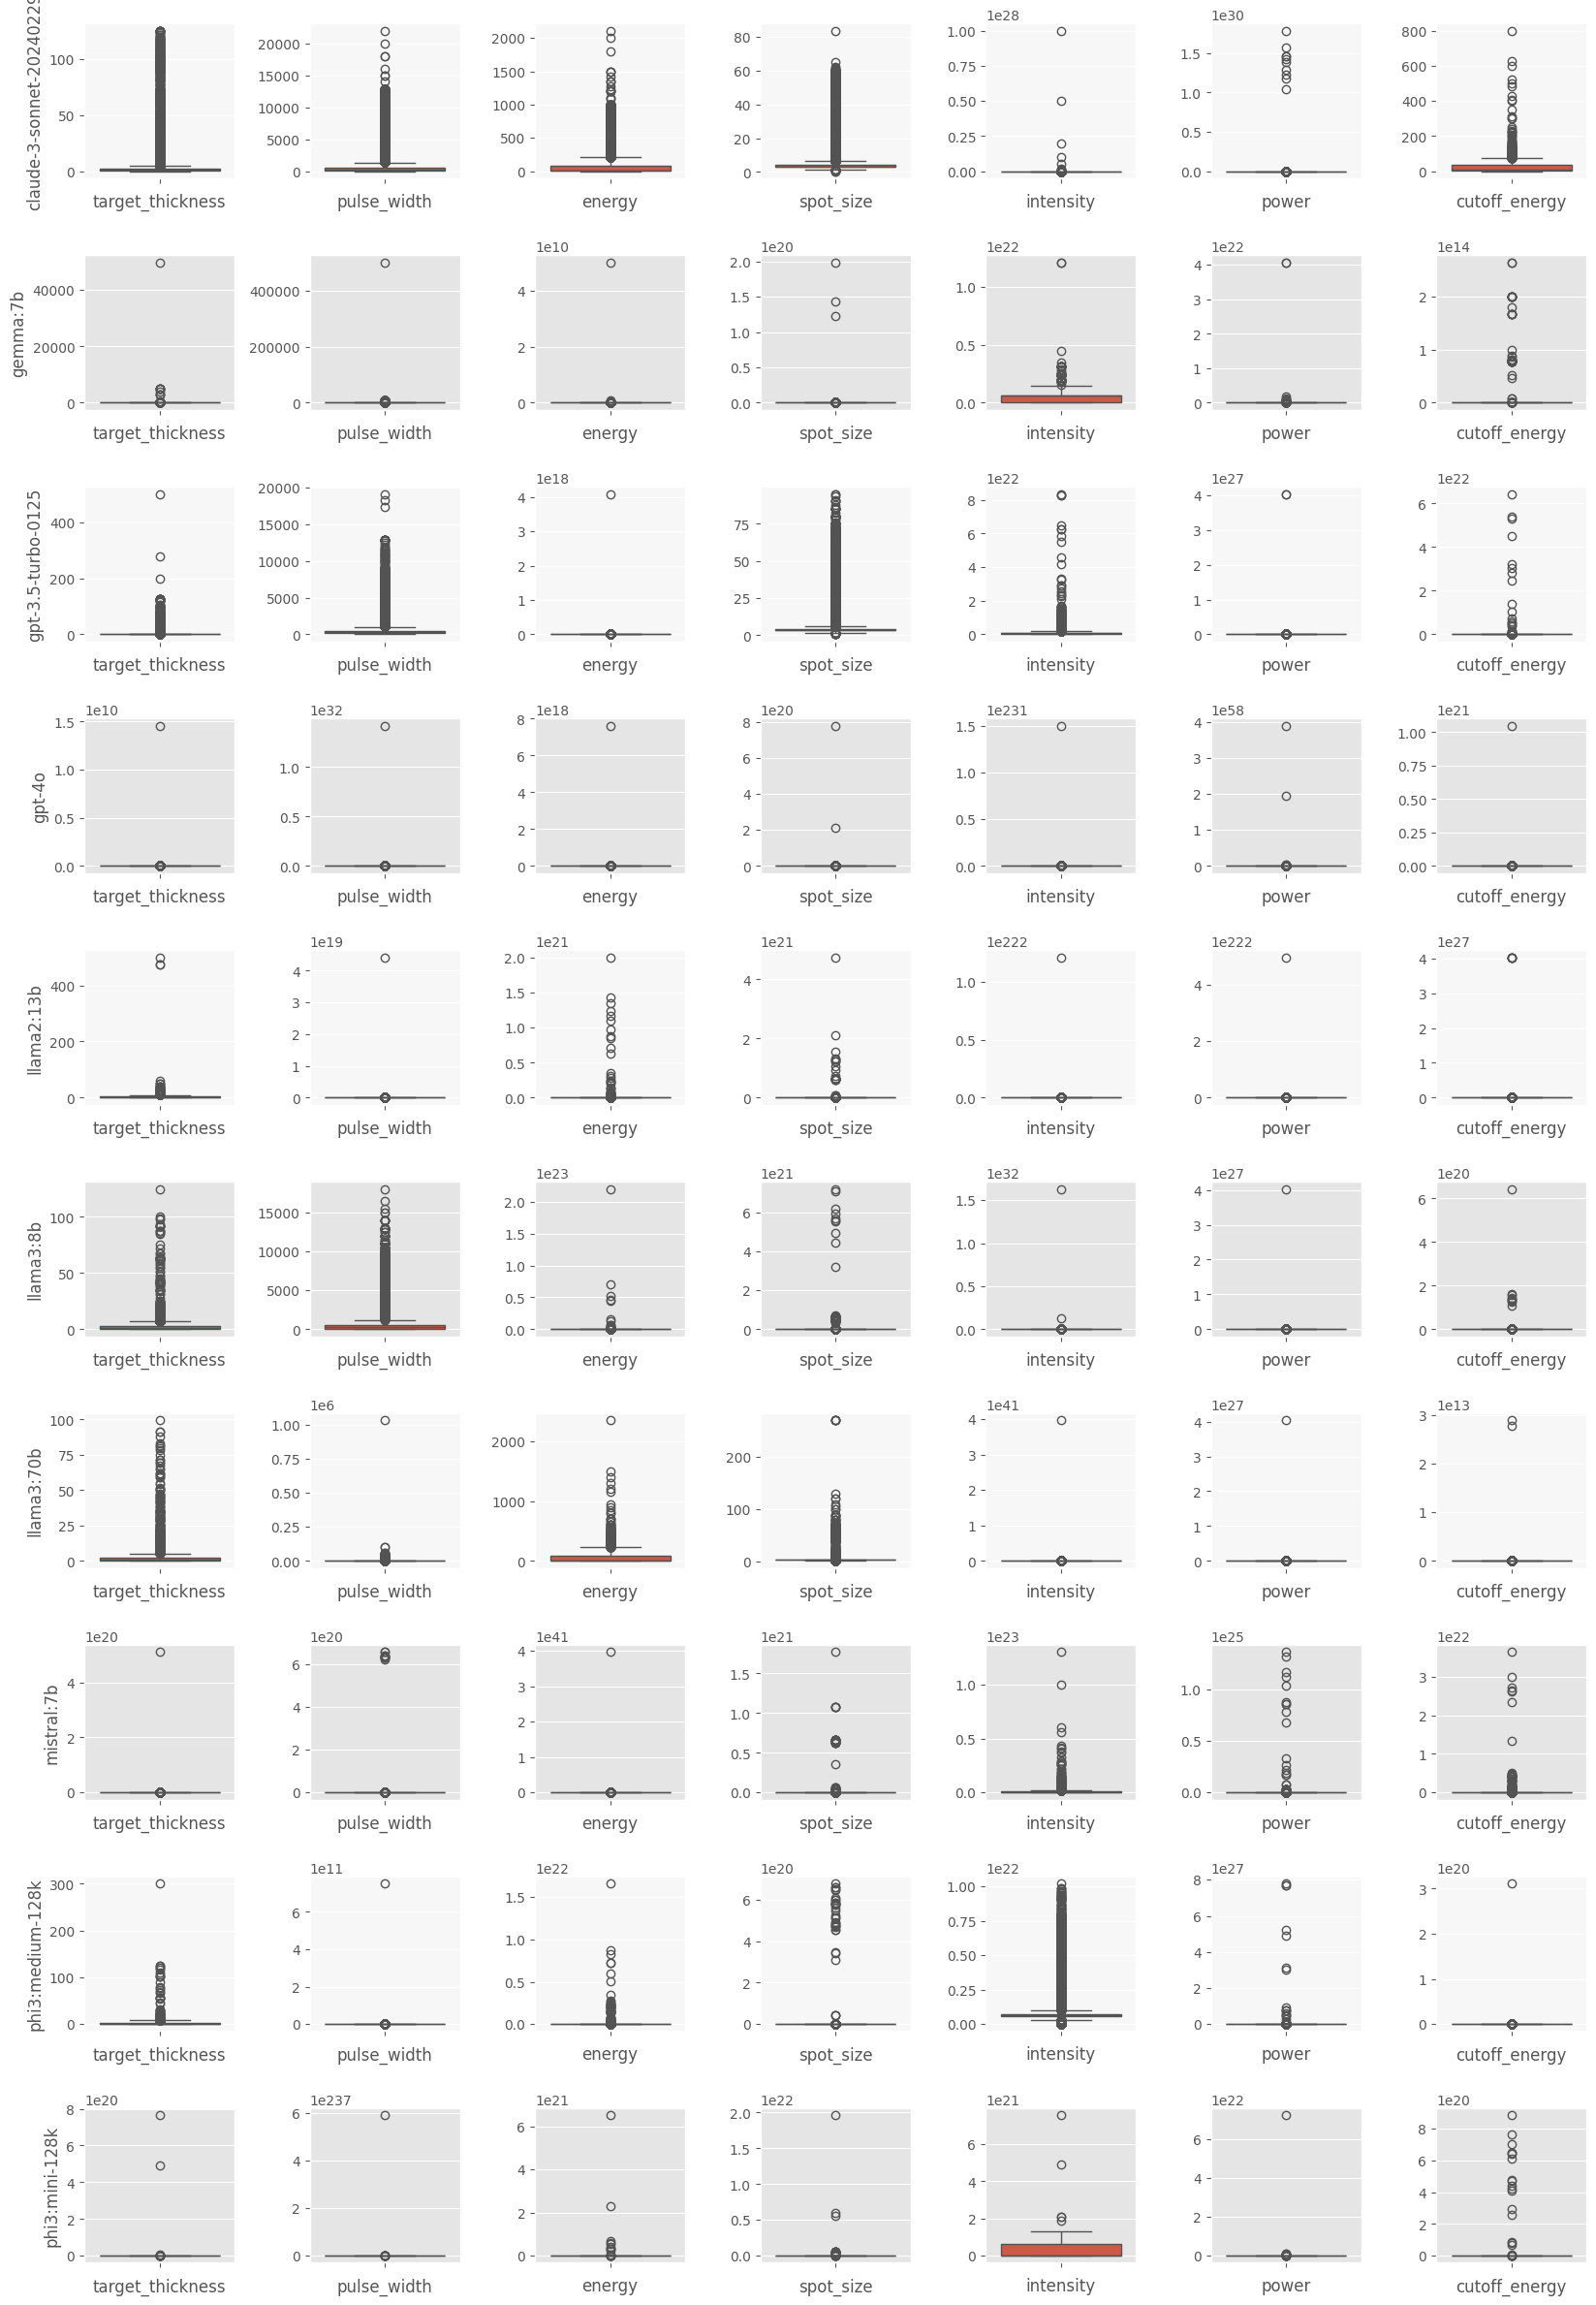

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

num_models = len(df['model'].unique())
# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, len(numeric_features), figsize=(20, 3 * num_models))

for i, model_name in enumerate(df['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df[df['model'] == model_name]

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        ax = sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v')
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel(feature)
        
        # Only set the ylabel for the first column
        if j == 0:
            axes[i, j].set_ylabel(model_name)
        else:
            axes[i, j].set_ylabel('')  # Remove y-label for other columns

        # Add shaded background for alternating rows
        if i % 2 == 0:  # Shade only even indexed rows (Python indexing starts at 0)
            ax.patch.set_facecolor((0.97, 0.97, 0.97))  # Light grey color, adjust the RGB values as needed

# Increase spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.savefig('./images/boxplot_outliers_models.jpg',dpi=300)
# Display the plot
plt.show()


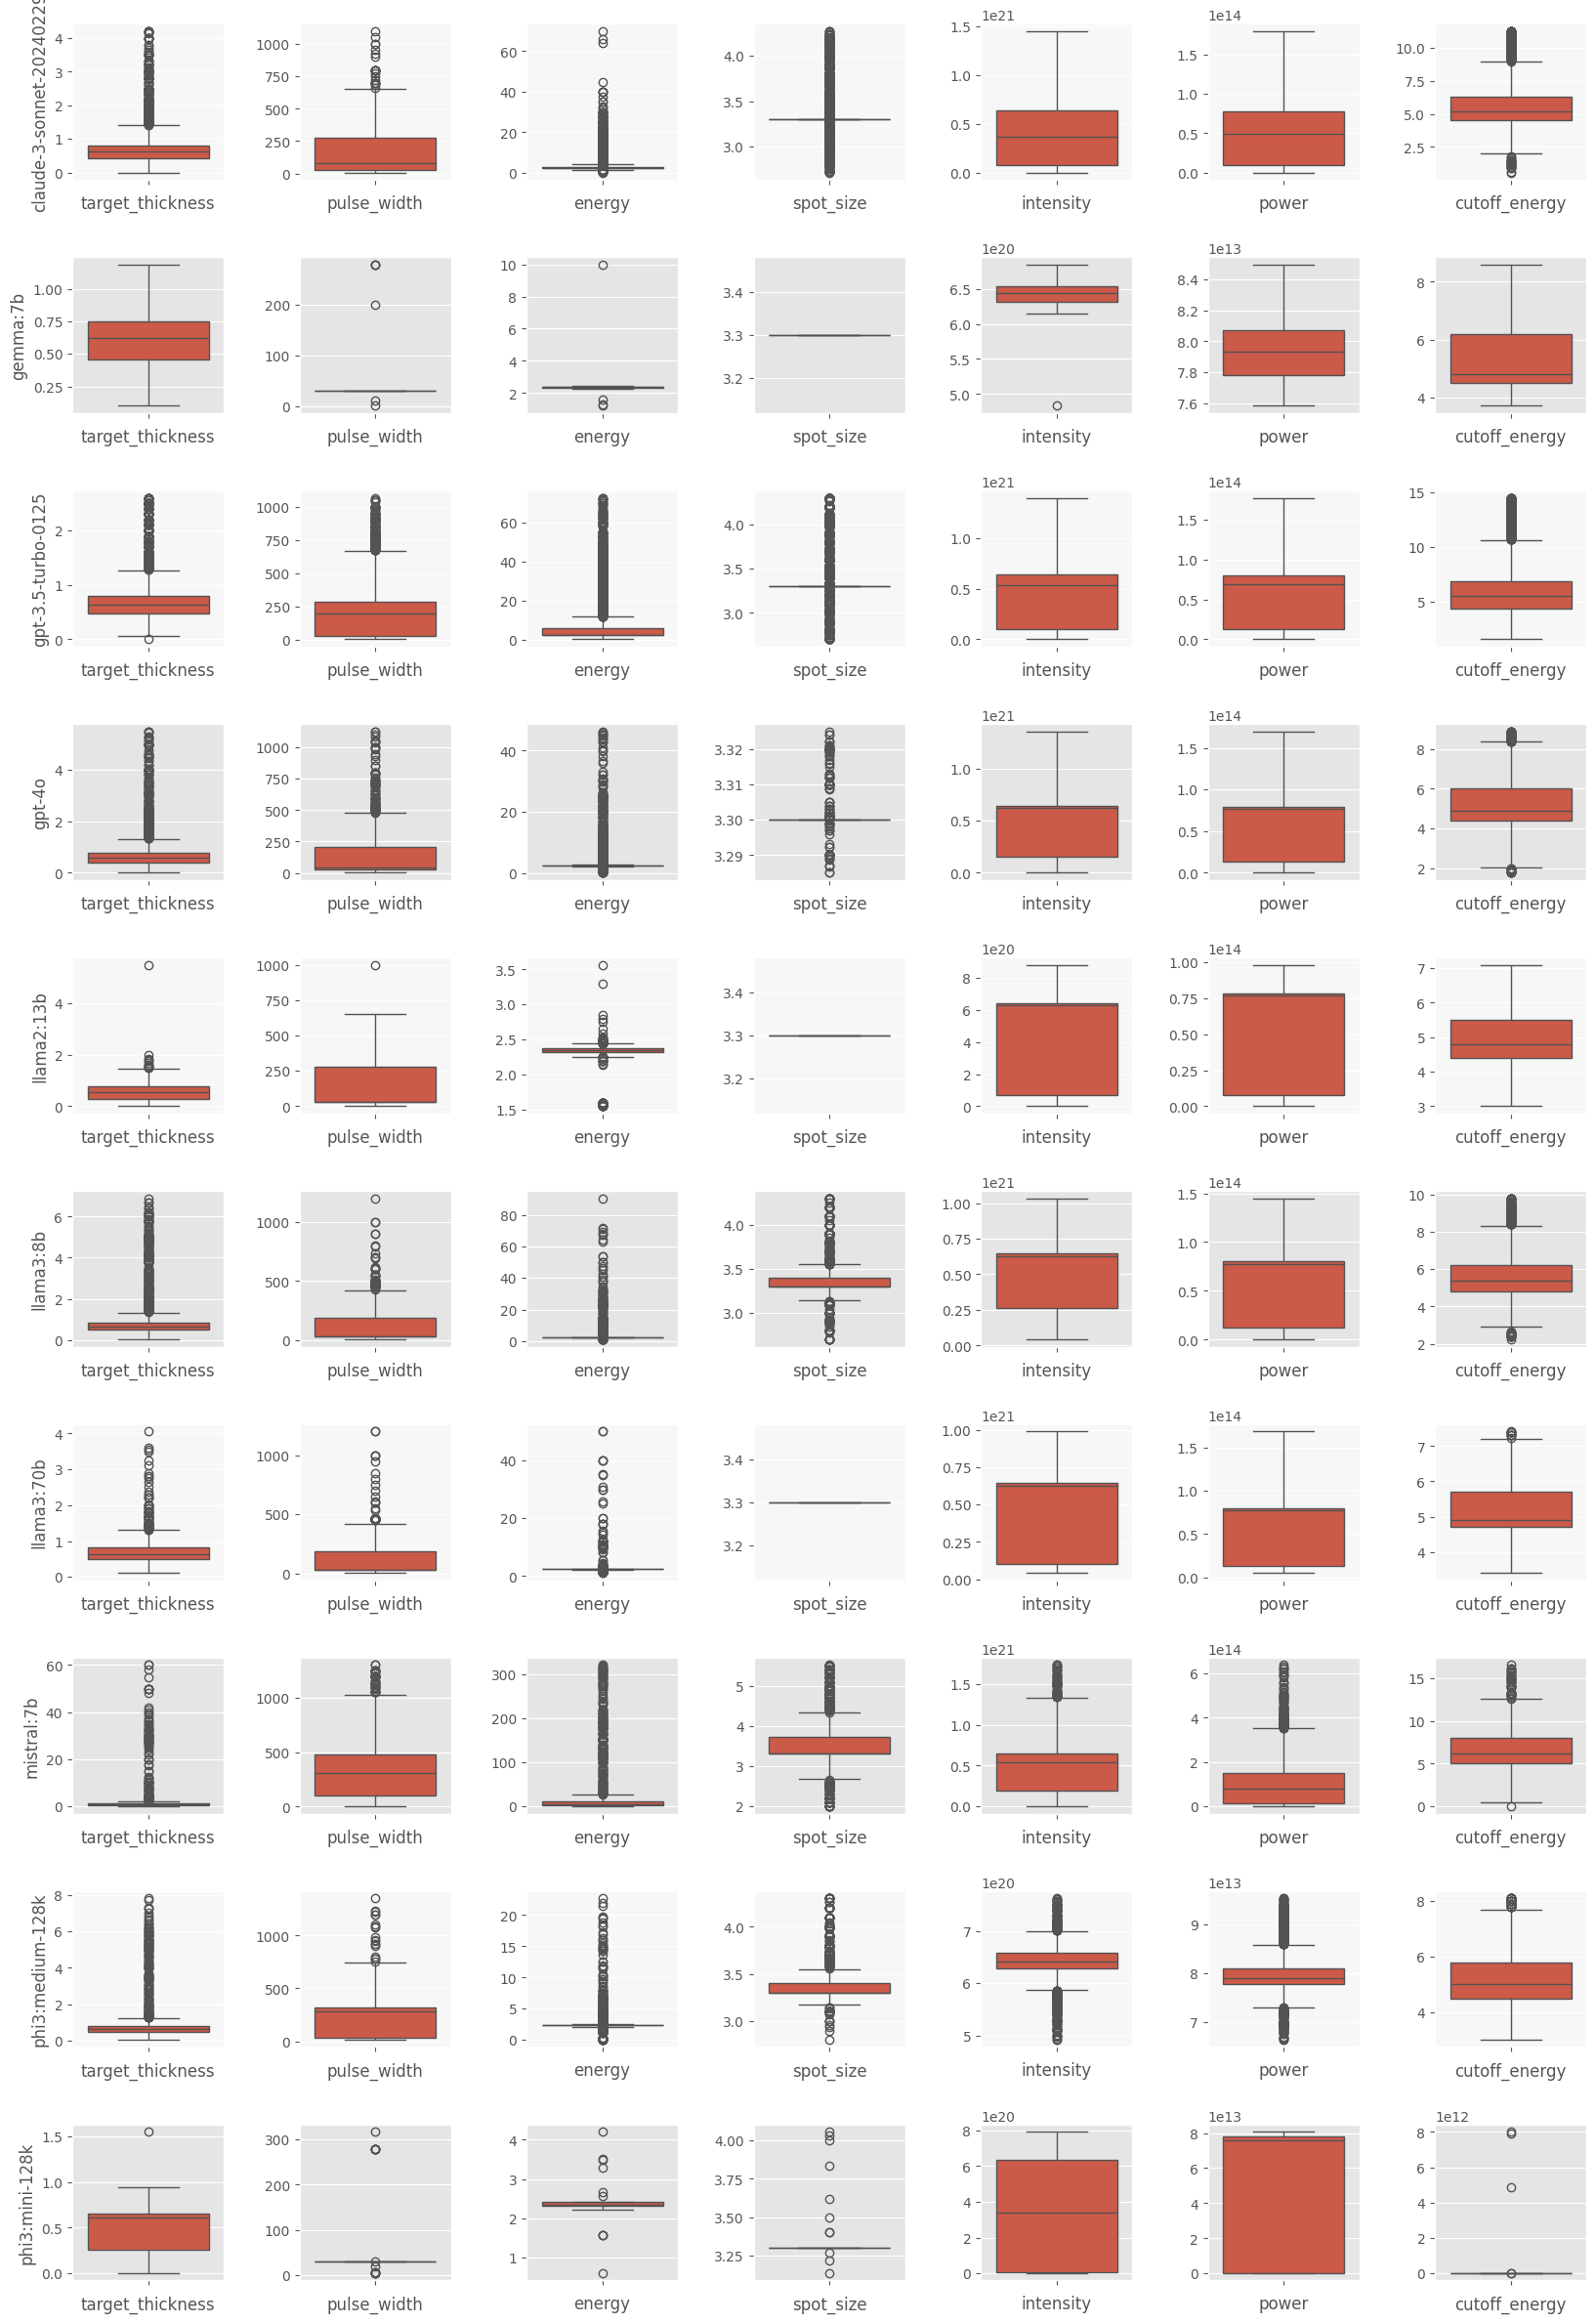

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assuming 'df' is your DataFrame
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

num_models = len(df['model'].unique())
# Initialize the matplotlib figure with subplots
fig, axes = plt.subplots(num_models, len(numeric_features), figsize=(20, 3 * num_models))

# Function to remove outliers for a specific feature
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

for i, model_name in enumerate(df['model'].unique()):
    # Filter the DataFrame for the specific model
    model_df = df[df['model'] == model_name]

    # Remove outliers for all numeric features
    for feature in numeric_features:
        model_df = remove_outliers(model_df, feature)

    for j, feature in enumerate(numeric_features):
        # Create a boxplot for the numeric features of this specific model
        ax = sns.boxplot(data=model_df, y=feature, ax=axes[i, j], orient='v')
        # Set the xlabel on each subplot
        axes[i, j].set_xlabel(feature)
        
        # Only set the ylabel for the first column
        if j == 0:
            axes[i, j].set_ylabel(model_name)
        else:
            axes[i, j].set_ylabel('')  # Remove y-label for other columns
        
        # Add shaded background for alternating rows
        if i % 2 == 0:  # Shade only even indexed rows (Python indexing starts at 0)
            ax.patch.set_facecolor((0.97, 0.97, 0.97))  # Light grey color, adjust the RGB values as needed

# Increase spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Save and display the plot
plt.savefig('./images/boxplot_outliers_remove_iqr1_5_models.jpg', dpi=300)
plt.show()


In [6]:
# Assuming 'df' is your DataFrame
numeric_features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Create a copy of the original DataFrame
df_remove_outliers = df.copy()

# Function to remove outliers for a specific feature
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.10)
    Q3 = df[feature].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Remove outliers for all numeric features
for feature in numeric_features:
    df_remove_outliers = remove_outliers(df_remove_outliers, feature)

print(f"Original DataFrame length: {len(df)}")
print(f"DataFrame length after removing outliers: {len(df_remove_outliers)}")

df_remove_outliers

Original DataFrame length: 123330
DataFrame length after removing outliers: 97418


model                        prompt_method  \
0       claude-3-sonnet-20240229                     chain_of_thought   
1       claude-3-sonnet-20240229                     chain_of_thought   
2       claude-3-sonnet-20240229                     chain_of_thought   
3       claude-3-sonnet-20240229                     chain_of_thought   
4       claude-3-sonnet-20240229                     chain_of_thought   
...                          ...                                  ...   
123308            phi3:mini-128k  recursive_criticism_and_improvement   
123309            phi3:mini-128k  recursive_criticism_and_improvement   
123310            phi3:mini-128k  recursive_criticism_and_improvement   
123315            phi3:mini-128k  recursive_criticism_and_improvement   
123316            phi3:mini-128k                    reverse_prompting   

       prompt_short  sample_size target_material target_thickness pulse_width  \
0               cot    rs_size_5         plastic             0.48          30   
1               cot    rs_size_5       aluminium              0.3          30   
2               cot    rs_size_5         plastic             0.62          30   
3               cot    rs_size_5   polypropylene             0.76         279   
4               cot    rs_size_5            gold             0.78         475   
...             ...          ...             ...              ...         ...   
123308         rcai   rs_size_50            gold              1.1         500   
123309         rcai   rs_size_50         plastic             0.62         279   
123310         rcai   rs_size_50   polypropylene              0.8         500   
123315         rcai  rs_size_150             mrk            0.525       4.934   
123316           rp   rs_size_25         plastic            0.263          30   

        energy spot_size                 intensity            power  \
0         2.31       3.3     625000000000000000000   76900000000000   
1         1.65       3.3      44600000000000000000    5490000000000   
2         2.39       3.3     646000000000000000000   79500000000000   
3         2.41       3.3     652000000000000000000   80200000000000   
4         10.5       3.3  1150000000000000000000.0  141000000000000   
...        ...       ...                       ...              ...   
123308   54.27     2.127  2118000000000000000000.0  108500000000000   
123309   2.375       3.3      64500000000000000000   80000000000000   
123310  146.61     4.406  1334000000000000000000.0  293200000000000   
123315   3.539       4.3                       0.0              6.2   
123316   2.327       3.3     628900000000000000000   77560000000000   

       cutoff_energy  
0                5.4  
1                4.2  
2                5.6  
3                5.6  
4               11.9  
...              ...  
123308            30  
123309             4  
123310          54.5  
123315           4.4  
123316           4.8  

[97418 rows x 12 columns]

/tmp/ipykernel_1285521/440557730.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1285521/440557730.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df['model'].fillna('original', inplace=True)


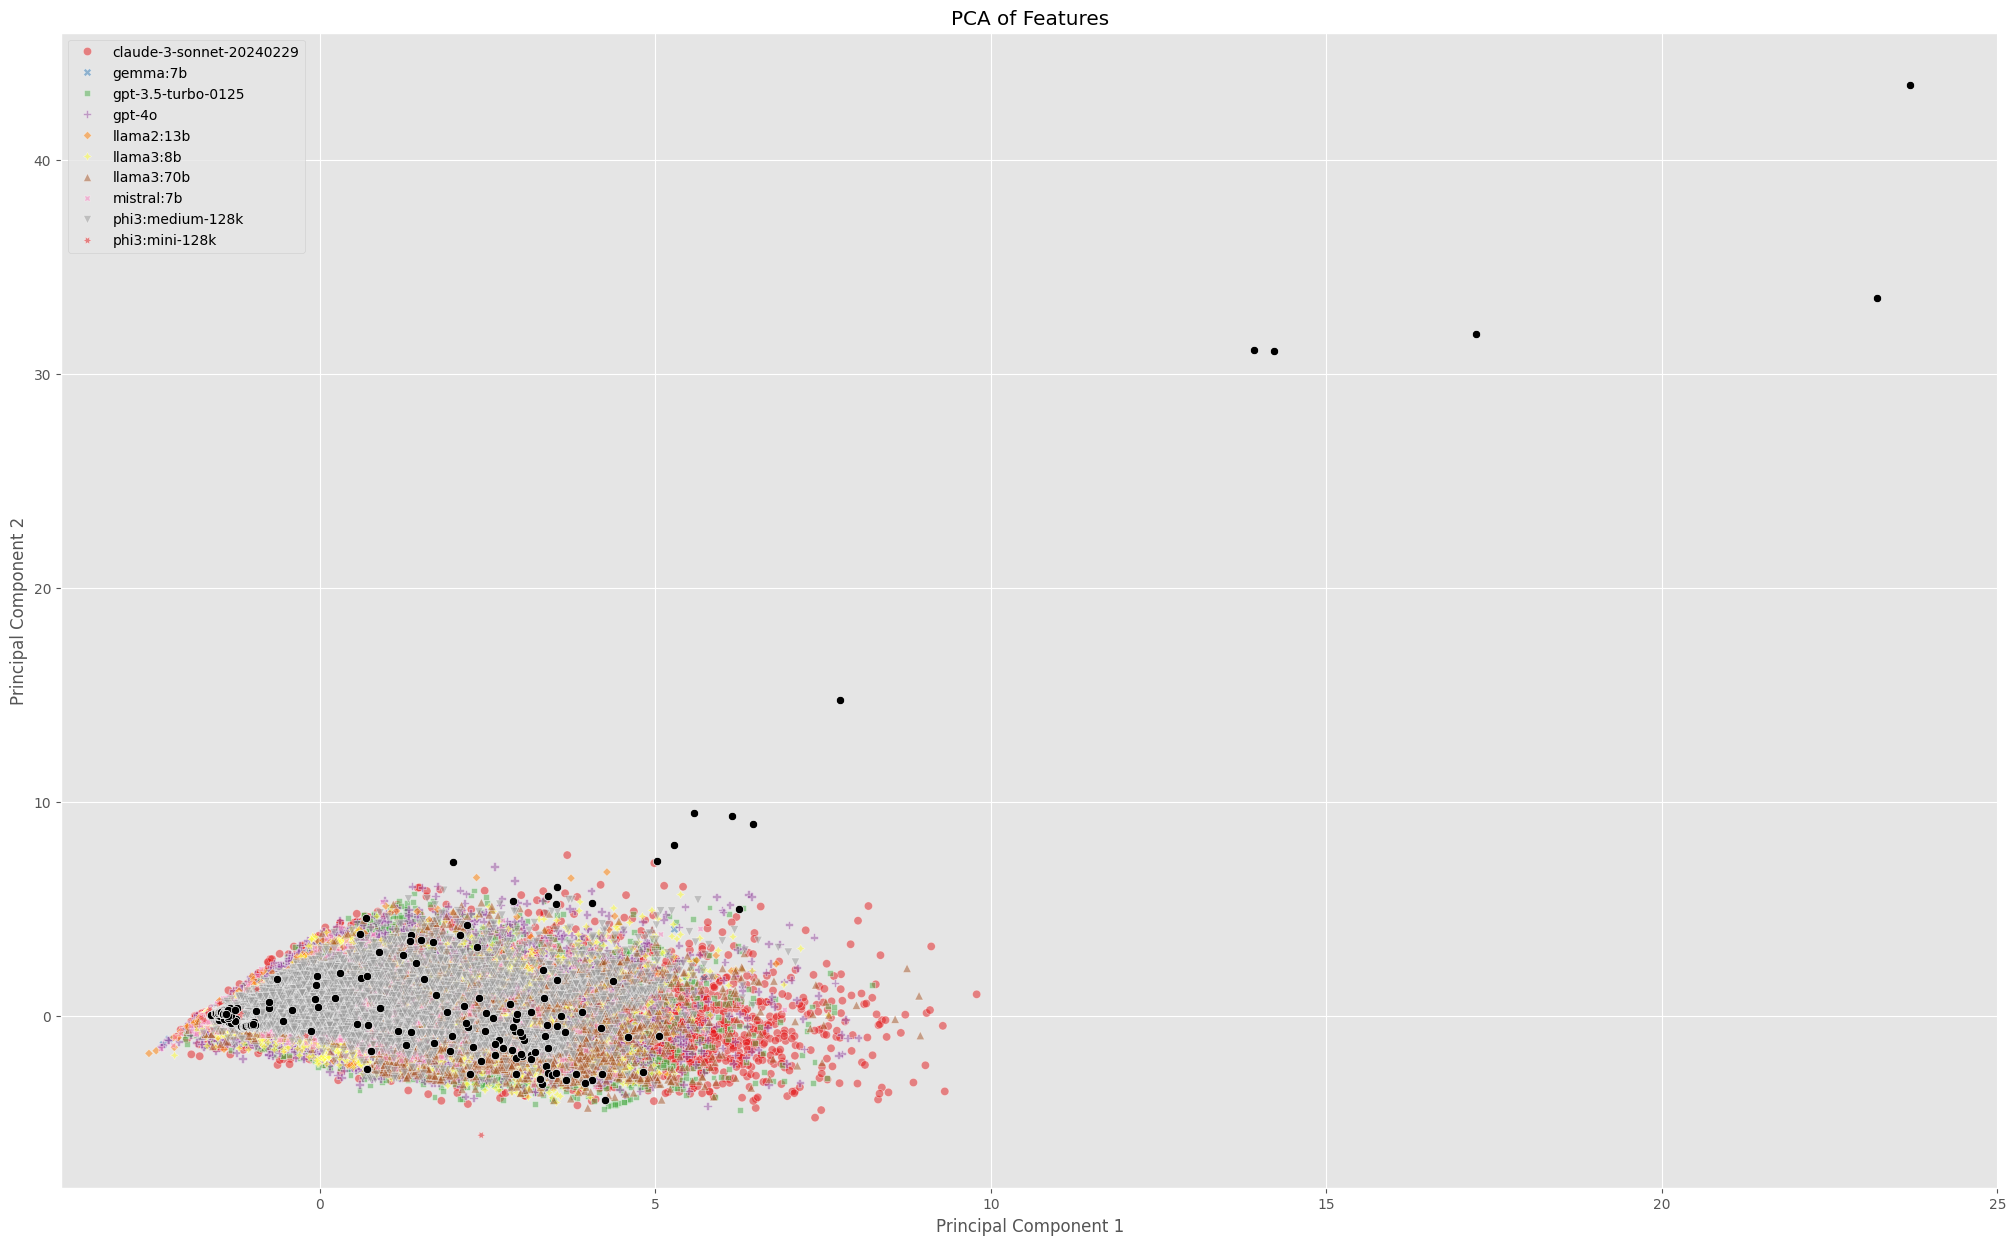

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(25, 15))

# Plot synthetic points first
sns.scatterplot(data=synthetic_points, x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=True)

# Plot original points on top in black
sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black')

plt.title('PCA of Features')
plt.show()


/tmp/ipykernel_1285521/673136415.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1285521/673136415.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df['model'].fillna('original', inplace=True)
/tmp/

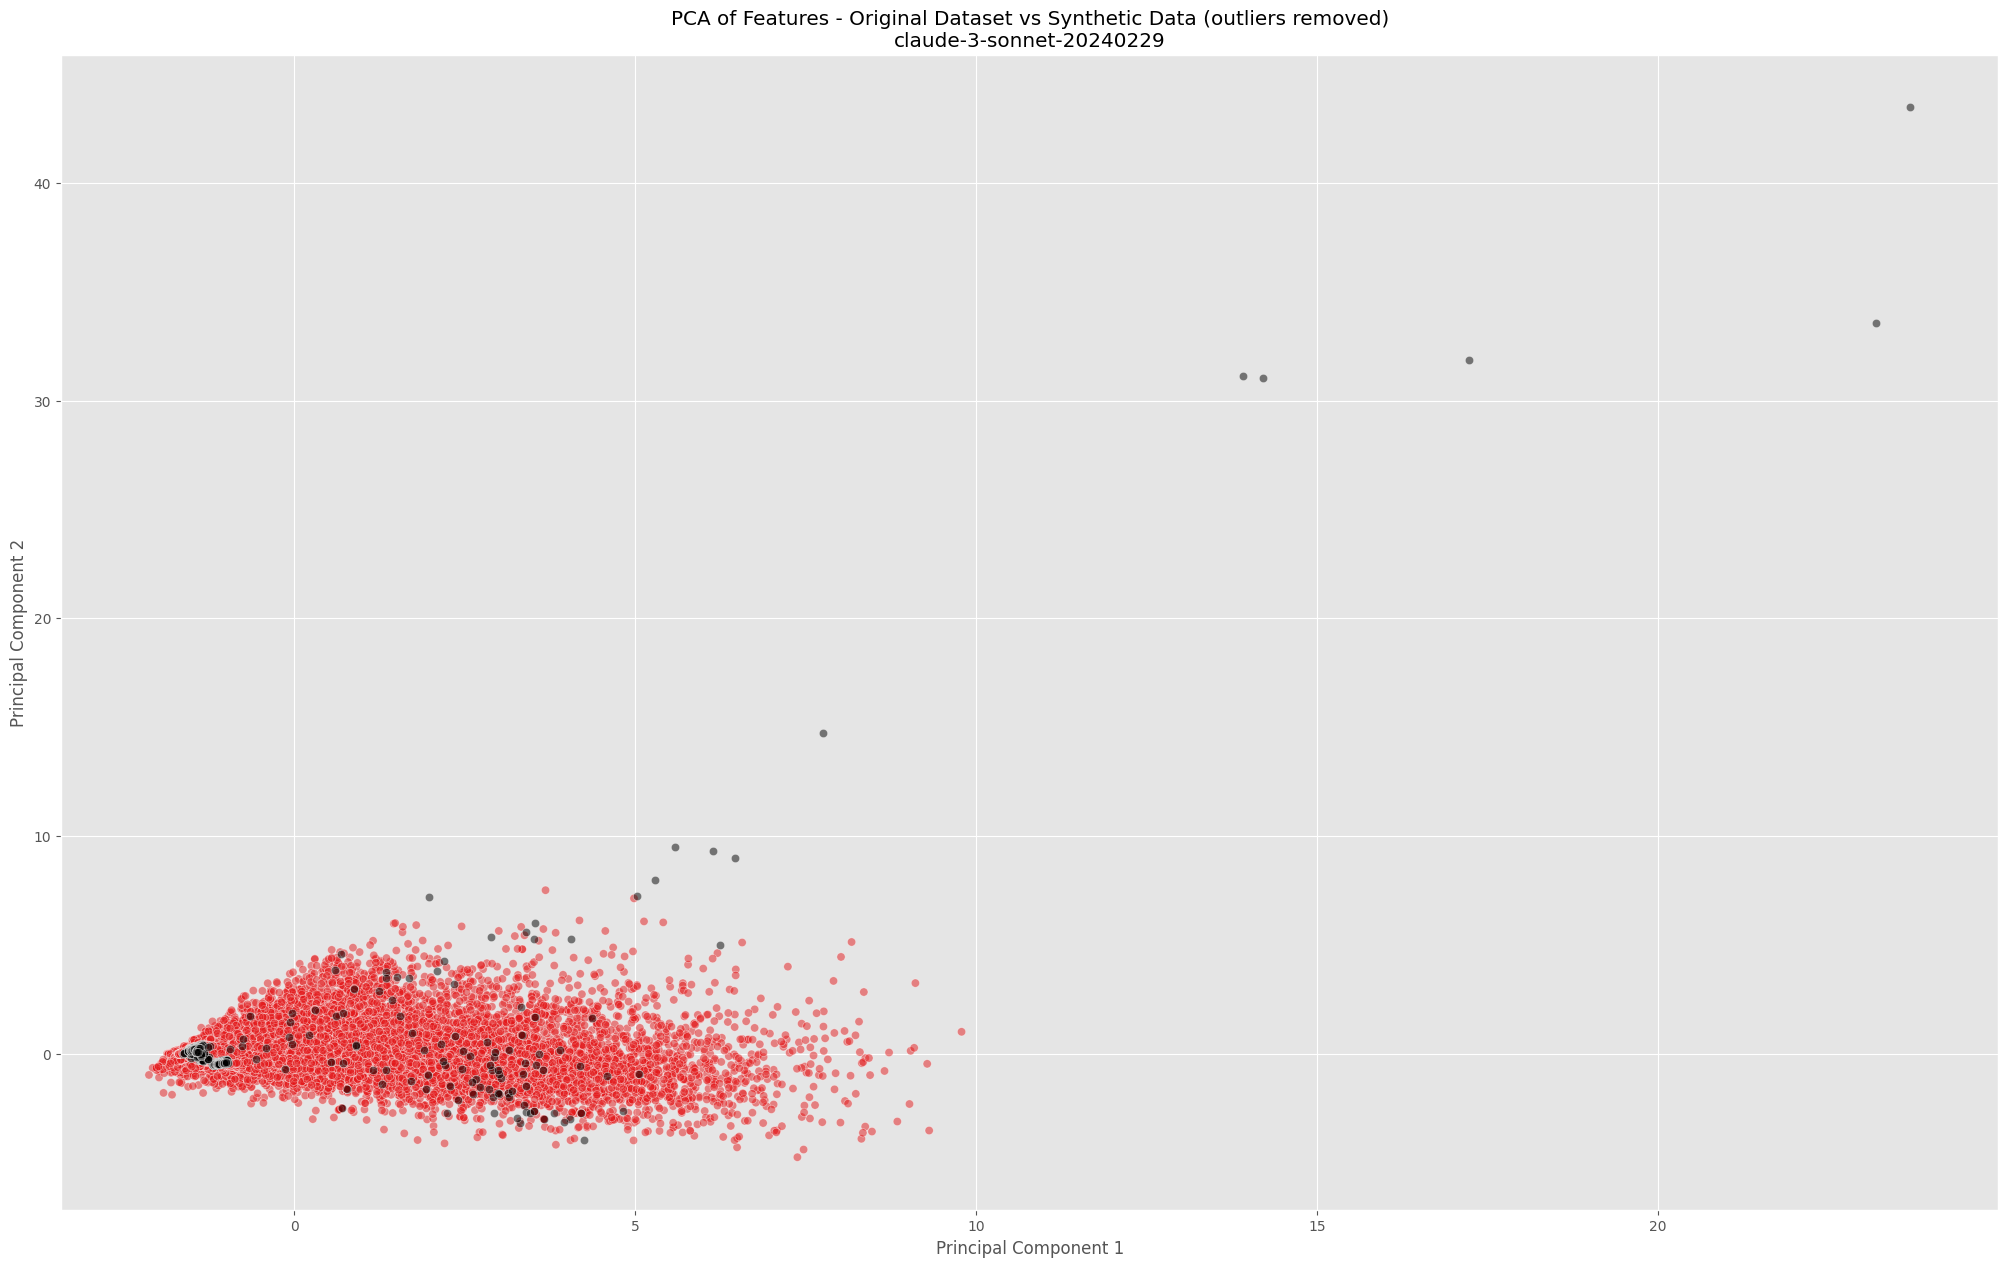

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


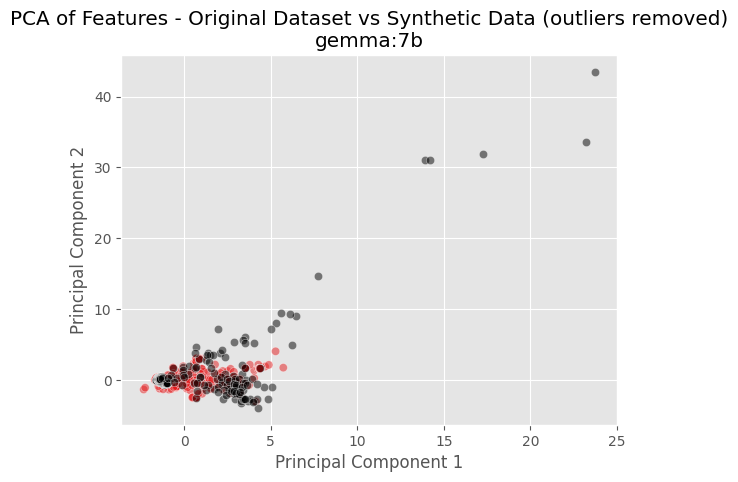

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


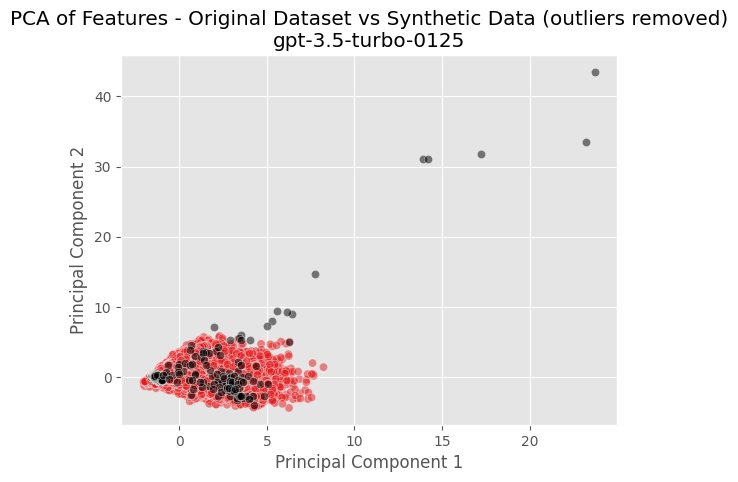

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


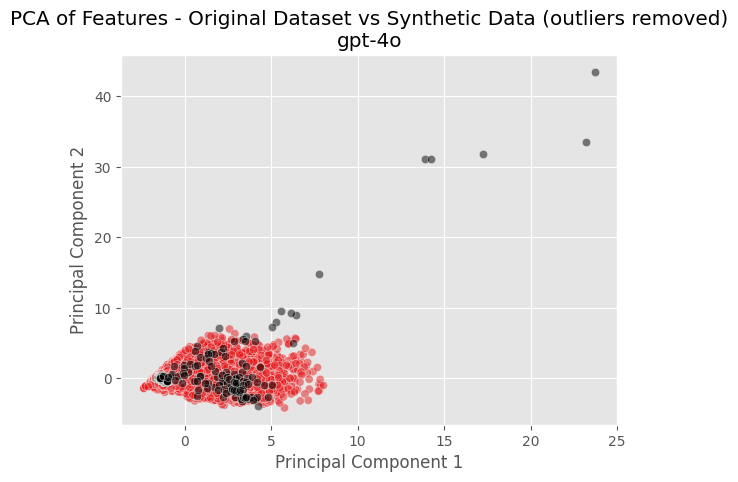

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


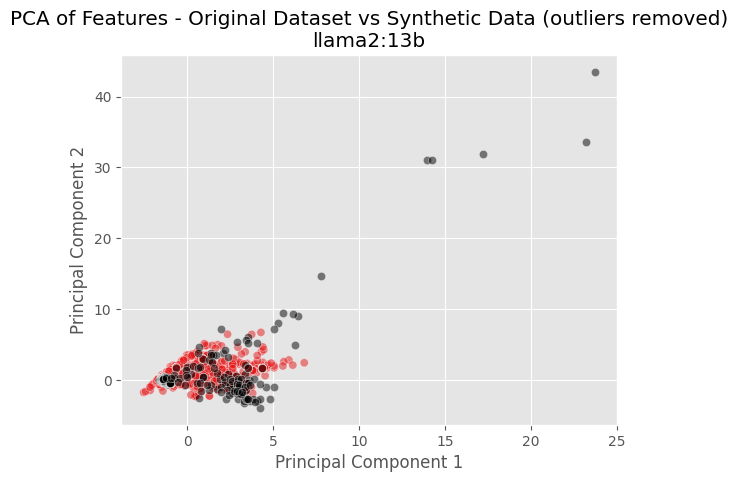

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


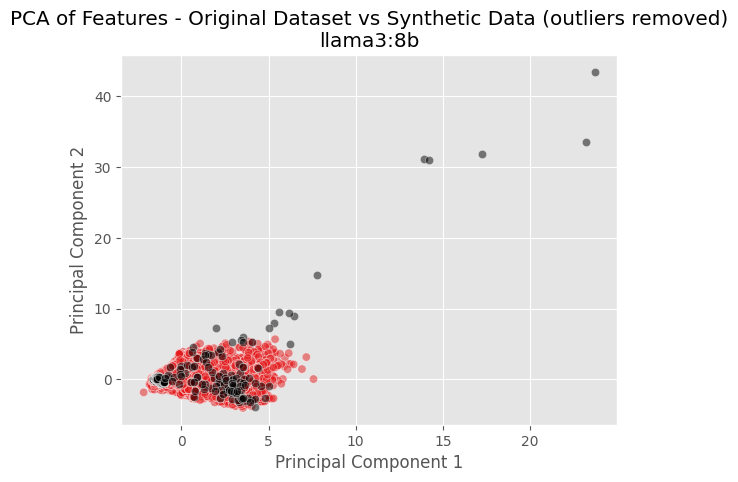

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


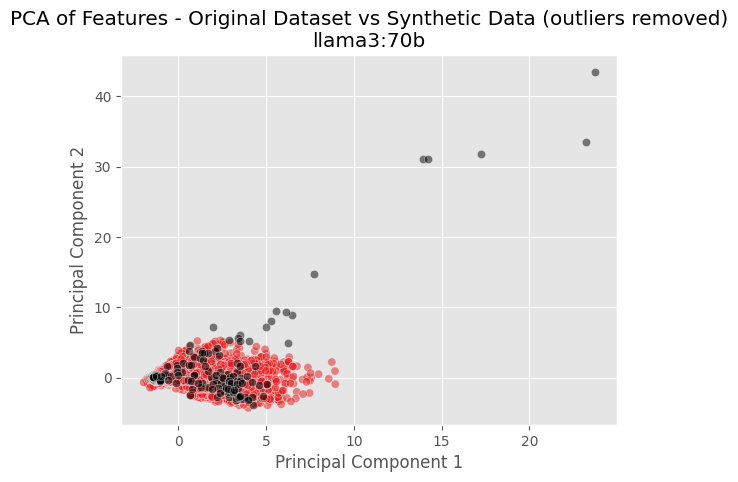

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


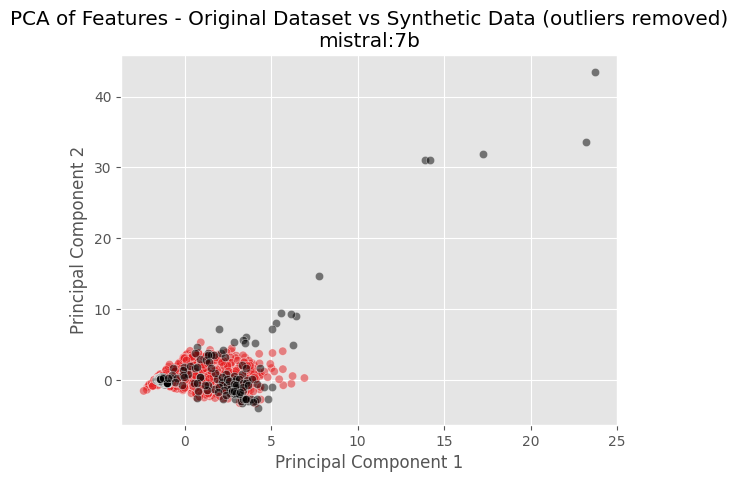

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


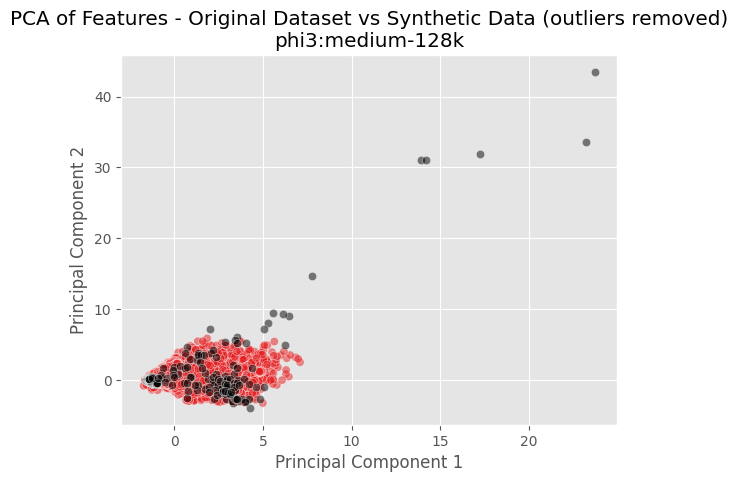

/tmp/ipykernel_1285521/673136415.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)


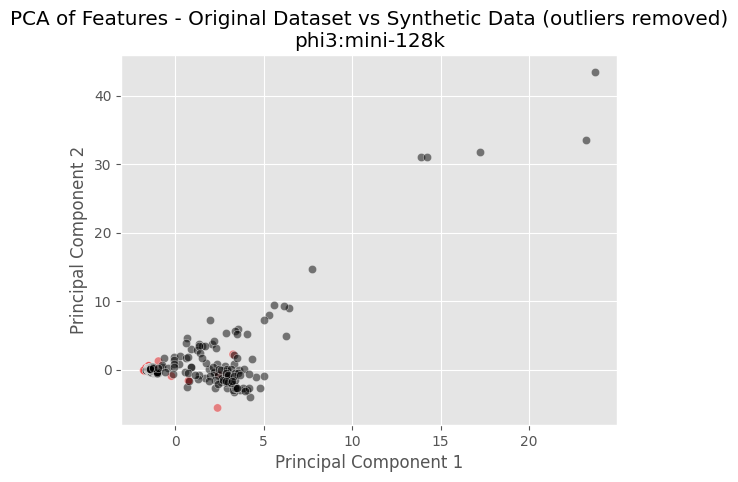

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Plotting the PCA result
plt.figure(figsize=(25, 15))

for i, model_name in enumerate(df['model'].unique()):
    # Plot synthetic points first
    sns.scatterplot(data=synthetic_points[pca_df['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False)

    # Plot original points on top in black
    sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black', alpha=0.5,)

    plt.title(f'PCA of Features - Original Dataset vs Synthetic Data (outliers removed)\n{model_name}')

    plt.savefig(f'./images/pca_original_vs_synth_{model_name}.jpg',dpi=300)
    plt.show()


/tmp/ipykernel_1285521/2276369470.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1285521/2276369470.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df['model'].fillna('original', inplace=True)


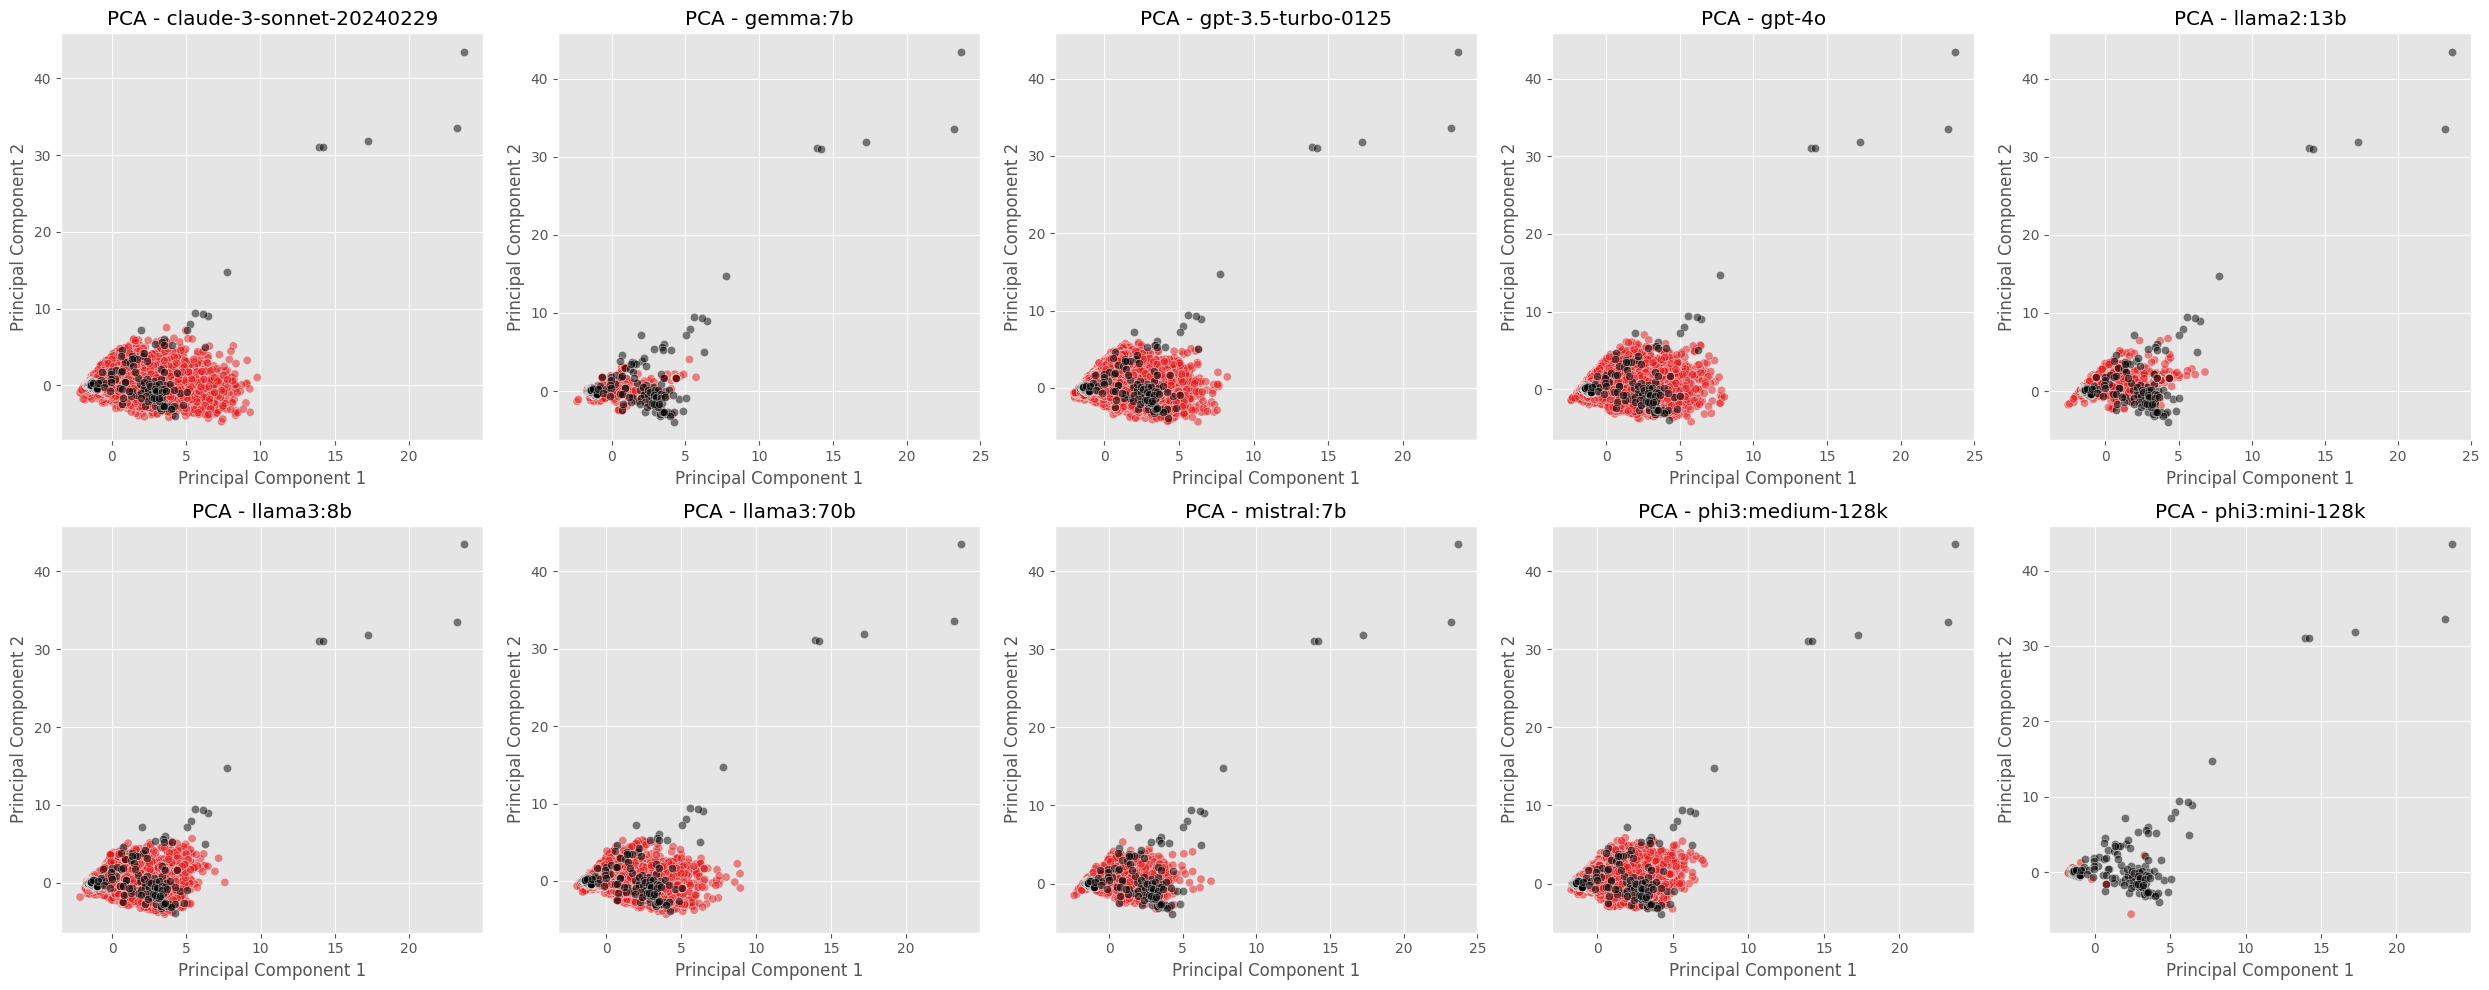

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for PCA
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Now proceed with PCA on the combined DataFrame
X = combined_df[features].copy()  # Create a copy to avoid SettingWithCopyWarning

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Proceed with PCA
pca = PCA(n_components=2)  # Example: reducing to 2 principal components
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Adding the source and model information back to the PCA DataFrame
pca_df = pd.concat([pca_df, combined_df.reset_index(drop=True)[['source', 'model']]], axis=1)

# Handle NaNs in the 'model' column for original data
pca_df['model'].fillna('original', inplace=True)

# Separate the synthetic and original data points
synthetic_points = pca_df[pca_df['source'] == 'synthetic']
original_points = pca_df[pca_df['source'] == 'original']

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()  # Flatten the 2D array of axes to iterate easily

for i, model_name in enumerate(df_remove_outliers['model'].unique()):
    ax = axes[i]
    # Plot synthetic points first
    sns.scatterplot(data=synthetic_points[synthetic_points['model'] == model_name], x='Principal Component 1', y='Principal Component 2', hue='model', style='model', palette='Set1', alpha=0.5, legend=False, ax=ax)

    # Plot original points on top in black
    sns.scatterplot(data=original_points, x='Principal Component 1', y='Principal Component 2', color='black', alpha=0.5, ax=ax)

    ax.set_title(f'PCA - {model_name}')

# Adjust layout
plt.tight_layout()

plt.savefig('./images/pca_all_models_orig_vs_synth.jpg',dpi=300)
plt.show()


In [10]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr

# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source and model columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model
kl_results = {}
models = df_remove_outliers['model'].unique()

for model_name in models:
    kl_results[model_name] = {}
    for feature in features:
        # Extract data for the current model
        synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['source'] == 'synthetic')][feature]
        original_data = scaled_df[scaled_df['source'] == 'original'][feature]
        
        # Calculate histograms (distributions) with smoothing
        bins = 30
        hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
        hist_original, _ = np.histogram(original_data, bins=bins, density=True)

        # Calculate KL Divergence
        kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
        kl_results[model_name][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'index': 'model'}, inplace=True)

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', '')] + [('KL Divergence', feature) for feature in kl_df.columns[1:]])

# Print KL Divergence DataFrame
#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 2:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted

/tmp/ipykernel_1285521/2492642627.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_1285521/2492642627.py:84: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])


Model    KL Divergence                                   \
                            target_thickness pulse_width    energy  spot_size   
3                    gpt-4o         5.105369    1.427642  2.371502  19.964118   
5                 llama3:8b         5.395976    1.370216  3.019422  19.902999   
0  claude-3-sonnet-20240229         5.267628    1.679902  3.143729  19.548346   
2        gpt-3.5-turbo-0125         4.880684    2.158128  2.481354  19.126260   
6                llama3:70b         5.662010    1.917347  3.648413   9.722162   
9            phi3:mini-128k         2.961534    4.622228  2.015068  19.691706   
4                llama2:13b         5.095668    2.038686  2.704547  19.582602   
8          phi3:medium-128k         6.243392    2.873434  3.040957  11.812721   
7                mistral:7b         6.140791    3.194785  2.681938  19.339141   
1                  gemma:7b         4.505599    1.237279  3.303630  20.032695   

                                     
  intensity     power cutoff_energy  
3  0.351579  1.440629      1.482780  
5  0.392727  1.394516      1.636624  
0  0.501105  1.251273      1.600869  
2  0.544062  1.332540      1.480810  
6  0.395461  2.025075      0.475522  
9  0.567473  1.938241      1.250096  
4  0.265889  1.283138      2.443497  
8  0.337537  1.669463      0.967050  
7  0.548545  1.585931      1.989872  
1  2.308867  2.125854      2.708176

In [17]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr

# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source, model, and prompt_method columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model and prompt method
kl_results = {}

for model_name in df_remove_outliers['model'].unique():
    for prompt_method in df_remove_outliers['prompt_method'].unique():
        key = (model_name, prompt_method)
        kl_results[key] = {}
        for feature in features:
            # Extract data for the current model and prompt method
            synthetic_data = scaled_df[(scaled_df['model'] == model_name) & (scaled_df['prompt_method'] == prompt_method) & (scaled_df['source'] == 'synthetic')][feature]
            original_data = scaled_df[scaled_df['source'] == 'original'][feature]

            # Calculate histograms (distributions) with smoothing
            bins = 30
            hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
            hist_original, _ = np.histogram(original_data, bins=bins, density=True)

            # Calculate KL Divergence
            kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
            kl_results[key][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'level_0': 'model', 'level_1': 'prompt_method'}, inplace=True)

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', ''), ('Prompt Method', '')] + [('KL Divergence', feature) for feature in kl_df.columns[2:]])

#kl_df

# Calculate the mean of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 2:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])

# Print the sorted DataFrame
kl_df_sorted.head(10)


/tmp/ipykernel_1285521/2467281141.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/fox/Desktop/ThesisLLM/Coding/gpt4/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_1285521/2467281141.py:86: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  kl_df_sorted = kl_df_sorted.drop(columns=['median_kl'])


Model                        Prompt Method  \
                                                                    
13                  gemma:7b                  skeleton_of_thought   
36                    gpt-4o                     chain_of_thought   
1   claude-3-sonnet-20240229                  skeleton_of_thought   
2   claude-3-sonnet-20240229                     self_consistency   
42                    gpt-4o                  step_back_prompting   
62                 llama3:8b                     self_consistency   
46                    gpt-4o  recursive_criticism_and_improvement   
3   claude-3-sonnet-20240229                  generated_knowledge   
60                 llama3:8b                     chain_of_thought   
64                 llama3:8b                        least_to_most   

      KL Divergence                                                       \
   target_thickness pulse_width    energy  spot_size intensity     power   
13         3.356817    1.299094  0.165922   0.692271  3.252486  0.452676   
36         4.841242    1.188564  1.374867  19.932571  0.571724  1.209925   
1          4.633515    1.292917  2.229769   8.026864  0.287315  1.244179   
2          3.350696    0.829849  1.806725   7.084503  0.108788  1.305294   
42         4.603612    1.113460  1.313128  10.471115  0.498787  1.085718   
62         4.278024    1.069994  3.341662   9.044591  0.446070  1.365997   
46         5.091830    1.383842  2.024501  19.767102  0.539184  1.406252   
3          4.475376    1.132809  2.403371   7.703808  0.228261  1.419359   
60         5.202111    1.423647  3.680043  18.350248  0.737779  1.456955   
64         5.750155    1.464595  4.057290  16.653020  0.459585  1.452337   

                  
   cutoff_energy  
13      0.657407  
36      1.282480  
1       0.337730  
2       0.621483  
42      1.897817  
62      0.728901  
46      0.823995  
3       0.192288  
60      0.921692  
64      1.115781

In [12]:
import pandas as pd
import numpy as np
from scipy.special import rel_entr

# Assuming df_remove_outliers and df_original are already loaded

# Selecting numerical features for KL Divergence
features = ['target_thickness', 'pulse_width', 'energy', 'spot_size', 'intensity', 'power', 'cutoff_energy']

# Ensure df_original has all columns from df_remove_outliers
missing_cols = set(df_remove_outliers.columns) - set(df_original.columns)
for col in missing_cols:
    df_original[col] = np.nan

# Add 'source' column
df_remove_outliers['source'] = 'synthetic'
df_original['source'] = 'original'

# Drop NaN values only from the synthetic data
df_remove_outliers_clean = df_remove_outliers.copy()
df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_remove_outliers_clean.dropna(subset=features, inplace=True)

# Combine the cleaned synthetic DataFrame with the original DataFrame
combined_df = pd.concat([df_remove_outliers_clean, df_original], ignore_index=True)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_df[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)

# Add the source, model, prompt_method, and sample_size columns back to the scaled DataFrame
scaled_df['source'] = combined_df['source'].values
scaled_df['model'] = combined_df['model'].values
scaled_df['prompt_method'] = combined_df['prompt_method'].values
scaled_df['sample_size'] = combined_df['sample_size'].values

# Function to calculate KL Divergence with smoothing
def calculate_kl_divergence(p, q, epsilon=1e-10):
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return np.sum(rel_entr(p, q))

# Calculate KL Divergence for each feature within each model, prompt method, and sample size
kl_results = {}
row_counts = {}

for model_name in df_remove_outliers['model'].unique():
    for prompt_method in df_remove_outliers['prompt_method'].unique():
        for sample_size in df_remove_outliers['sample_size'].unique():
            key = (model_name, prompt_method, sample_size)
            kl_results[key] = {}
            # Calculate row count for the current combination
            row_counts[key] = len(scaled_df[(scaled_df['model'] == model_name) & 
                                            (scaled_df['prompt_method'] == prompt_method) & 
                                            (scaled_df['sample_size'] == sample_size) & 
                                            (scaled_df['source'] == 'synthetic')])
            for feature in features:
                # Extract data for the current model, prompt method, and sample size
                synthetic_data = scaled_df[(scaled_df['model'] == model_name) & 
                                           (scaled_df['prompt_method'] == prompt_method) & 
                                           (scaled_df['sample_size'] == sample_size) & 
                                           (scaled_df['source'] == 'synthetic')][feature]
                original_data = scaled_df[scaled_df['source'] == 'original'][feature]

                # Calculate histograms (distributions) with smoothing
                bins = 30
                hist_synthetic, _ = np.histogram(synthetic_data, bins=bins, density=True)
                hist_original, _ = np.histogram(original_data, bins=bins, density=True)

                # Calculate KL Divergence
                kl_divergence = calculate_kl_divergence(hist_synthetic, hist_original)
                kl_results[key][feature] = kl_divergence

# Convert the KL results into a DataFrame
kl_df = pd.DataFrame(kl_results).T
kl_df.reset_index(inplace=True)
kl_df.rename(columns={'level_0': 'model', 'level_1': 'prompt_method', 'level_2': 'sample_size'}, inplace=True)

# Add row counts to the DataFrame
kl_df['row_count'] = [row_counts[(row['model'], row['prompt_method'], row['sample_size'])] for _, row in kl_df.iterrows()]

# Create a MultiIndex for the columns
kl_df.columns = pd.MultiIndex.from_tuples([('Model', ''), ('Prompt Method', ''), ('Sample Size', ''), ('Row Count', '')] + [('KL Divergence', feature) for feature in kl_df.columns[4:]])

# Calculate the median of the KL divergence features for each row
kl_df['median_kl'] = kl_df.iloc[:, 4:].median(axis=1)

# Sort the DataFrame by this new column in descending order
kl_df_sorted = kl_df.sort_values(by='median_kl', ascending=True)
kl_df_sorted.dropna(inplace=True)

# Drop the temporary mean column
kl_df_sorted = kl_df_sorted.drop(columns=[('median_kl', '')])

# Print the sorted DataFrame
kl_df_sorted

/tmp/ipykernel_1285521/2422790362.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_remove_outliers_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/home/fox/Desktop/ThesisLLM/Coding/gpt4/.venv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Model                        Prompt Method  \
                                                                     
211        gpt-3.5-turbo-0125                    reverse_prompting   
74                   gemma:7b                     chain_of_thought   
242                    gpt-4o                        least_to_most   
181        gpt-3.5-turbo-0125                  step_back_prompting   
255                    gpt-4o                  step_back_prompting   
..                        ...                                  ...   
503                llama3:70b                    reverse_prompting   
57   claude-3-sonnet-20240229                  directional_stimuli   
561                mistral:7b                  directional_stimuli   
568                mistral:7b  recursive_criticism_and_improvement   
537                mistral:7b                chain_of_verification   

     Sample Size  Row Count KL Divergence                                  \
                              pulse_width     energy  spot_size intensity   
211   rs_size_10   1.978757      7.678651   0.310124   6.320626  0.248663   
74    rs_size_25  16.305954      0.438499   0.508791   0.305833  4.372762   
242   rs_size_25   7.079870      4.535867   0.696028   8.001313  0.503975   
181   rs_size_10   2.214697      0.740889   0.720243  19.761115  0.567221   
255   rs_size_50   4.691466      1.711537   0.455435  18.795737  0.744025   
..           ...        ...           ...        ...        ...       ...   
503  rs_size_150  15.104391     11.013390  12.245655  13.629071  4.929561   
57    rs_size_50  10.244584     11.189128  13.983591  16.134472  1.067863   
561   rs_size_50  11.259982     11.515344  11.753493  15.194989  0.967694   
568  rs_size_100  14.774266     12.817534  13.214512  12.883615  3.264621   
537   rs_size_50  13.278817     13.851220  13.500995  13.857869  3.163047   

                                       
        power cutoff_energy row_count  
211  0.537030      0.385840       224  
74   4.781934      0.592347         9  
242  0.579993      0.531163       277  
181  1.694191      0.739336       324  
255  0.482137      0.692896       217  
..        ...           ...       ...  
503  3.026523      3.601648        11  
57   2.012682      2.576705       314  
561  1.250184      3.694985        23  
568  2.597196      8.252913        19  
537  2.627977      2.905572        18  

[560 rows x 11 columns]

In [13]:
kl_df_sorted.head(50)

Model                        Prompt Method  \
                                                                     
211        gpt-3.5-turbo-0125                    reverse_prompting   
74                   gemma:7b                     chain_of_thought   
242                    gpt-4o                        least_to_most   
181        gpt-3.5-turbo-0125                  step_back_prompting   
255                    gpt-4o                  step_back_prompting   
30   claude-3-sonnet-20240229                chain_of_verification   
164        gpt-3.5-turbo-0125                  generated_knowledge   
248                    gpt-4o                chain_of_verification   
156        gpt-3.5-turbo-0125                     self_consistency   
253                    gpt-4o                  step_back_prompting   
12   claude-3-sonnet-20240229                     self_consistency   
216                    gpt-4o                     chain_of_thought   
205        gpt-3.5-turbo-0125  recursive_criticism_and_improvement   
69   claude-3-sonnet-20240229                    reverse_prompting   
162        gpt-3.5-turbo-0125                  generated_knowledge   
238                    gpt-4o                  generated_knowledge   
144        gpt-3.5-turbo-0125                     chain_of_thought   
398                 llama3:8b                  step_back_prompting   
212        gpt-3.5-turbo-0125                    reverse_prompting   
188        gpt-3.5-turbo-0125                 rephrase_and_respond   
38   claude-3-sonnet-20240229                  step_back_prompting   
182        gpt-3.5-turbo-0125                  step_back_prompting   
254                    gpt-4o                  step_back_prompting   
409                 llama3:8b                       emotion_prompt   
27   claude-3-sonnet-20240229                        least_to_most   
276                    gpt-4o  recursive_criticism_and_improvement   
68   claude-3-sonnet-20240229                    reverse_prompting   
14   claude-3-sonnet-20240229                     self_consistency   
158        gpt-3.5-turbo-0125                     self_consistency   
157        gpt-3.5-turbo-0125                     self_consistency   
369                 llama3:8b                  skeleton_of_thought   
285                    gpt-4o                    reverse_prompting   
176        gpt-3.5-turbo-0125                chain_of_verification   
244                    gpt-4o                        least_to_most   
279                    gpt-4o  recursive_criticism_and_improvement   
518                mistral:7b                     self_consistency   
170        gpt-3.5-turbo-0125                        least_to_most   
32   claude-3-sonnet-20240229                chain_of_verification   
34   claude-3-sonnet-20240229                chain_of_verification   
338                llama2:13b                       emotion_prompt   
547                mistral:7b                 rephrase_and_respond   
220                    gpt-4o                     chain_of_thought   
62   claude-3-sonnet-20240229  recursive_criticism_and_improvement   
151        gpt-3.5-turbo-0125                  skeleton_of_thought   
21   claude-3-sonnet-20240229                  generated_knowledge   
13   claude-3-sonnet-20240229                     self_consistency   
221                    gpt-4o                     chain_of_thought   
246                    gpt-4o                chain_of_verification   
206        gpt-3.5-turbo-0125  recursive_criticism_and_improvement   
183        gpt-3.5-turbo-0125                  step_back_prompting   

     Sample Size  Row Count KL Divergence                                 \
                              pulse_width    energy  spot_size intensity   
211   rs_size_10   1.978757      7.678651  0.310124   6.320626  0.248663   
74    rs_size_25  16.305954      0.438499  0.508791   0.305833  4.372762   
242   rs_size_25   7.079870      4.535867  0.696028   8.001313  0.503975   
181

In [14]:
kl_df_sorted.tail(50)

Model                        Prompt Method  \
                                                                     
716            phi3:mini-128k                    reverse_prompting   
682            phi3:mini-128k                chain_of_verification   
132                  gemma:7b  recursive_criticism_and_improvement   
615          phi3:medium-128k                  step_back_prompting   
345                llama2:13b                  directional_stimuli   
99                   gemma:7b                        least_to_most   
102                  gemma:7b                chain_of_verification   
520                mistral:7b                     self_consistency   
78                   gemma:7b                  skeleton_of_thought   
339                llama2:13b                       emotion_prompt   
506                mistral:7b                     chain_of_thought   
80                   gemma:7b                  skeleton_of_thought   
324                llama2:13b                  step_back_prompting   
365                 llama3:8b                     chain_of_thought   
516                mistral:7b                     self_consistency   
53   claude-3-sonnet-20240229                       emotion_prompt   
127                  gemma:7b                  directional_stimuli   
360                 llama3:8b                     chain_of_thought   
196        gpt-3.5-turbo-0125                       emotion_prompt   
519                mistral:7b                     self_consistency   
642          phi3:medium-128k                    reverse_prompting   
419                 llama3:8b                  directional_stimuli   
59   claude-3-sonnet-20240229                  directional_stimuli   
84                   gemma:7b                     self_consistency   
161        gpt-3.5-turbo-0125                     self_consistency   
694            phi3:mini-128k                 rephrase_and_respond   
98                   gemma:7b                        least_to_most   
677            phi3:mini-128k                        least_to_most   
572                mistral:7b                    reverse_prompting   
591          phi3:medium-128k                     self_consistency   
525                mistral:7b                  generated_knowledge   
508                mistral:7b                     chain_of_thought   
399                 llama3:8b                  step_back_prompting   
388                 llama3:8b                        least_to_most   
504                mistral:7b                     chain_of_thought   
556                mistral:7b                       emotion_prompt   
90                   gemma:7b                  generated_knowledge   
407                 llama3:8b                 rephrase_and_respond   
130                  gemma:7b                  directional_stimuli   
51   claude-3-sonnet-20240229                       emotion_prompt   
89                   gemma:7b                     self_consistency   
402                 llama3:8b                 rephrase_and_respond   
58   claude-3-sonnet-20240229                  directional_stimuli   
118                  gemma:7b                 rephrase_and_respond   
179        gpt-3.5-turbo-0125                chain_of_verification   
503                llama3:70b                    reverse_prompting   
57   claude-3-sonnet-20240229                  directional_stimuli   
561                mistral:7b                  directional_stimuli   
568                mistral:7b  recursive_criticism_and_improvement   
537                mistral:7b                chain_of_verification   

     Sample Size  Row Count KL Divergence                                   \
                              pulse_width     energy  spot_size  intensity   
716   rs_size_25  22.319768     23.263253  23.537916   6.279459   6.279459   
682  rs_size_100  22.319768     23.263253  23.537916  22.488577   6.279459   
132    rs_size_5  22.319768     23.263253  23.537916  22.488577   6.279